In [1]:
import pandas as pd
import numpy as np
import pylab as plt
%matplotlib inline

In [71]:
# fragment_file = '../input/Beer_3_T10_POS_fragments.csv'
fragment_file = '/Users/simon/Downloads/Beer_3_full1_pos_fragments.csv'
data = pd.DataFrame.from_csv(fragment_file)

In [72]:
data = data.fillna(0)
data_array = np.array(data)
peak_names = list(data.columns.values)

In [73]:
l = np.sqrt((data_array**2).sum(axis=0))
norm_data = np.divide(data_array,l)

In [74]:
import scipy.spatial.distance as distance
import scipy.cluster.hierarchy

In [80]:
clustering = hierarchy.fclusterdata(norm_data.transpose(),1.0,metric='euclidean',method='single')

In [81]:
import networkx as nx

In [82]:
node_no = 0
G = nx.Graph()
uc = np.unique(clustering)
cluster_nodes = {}
for cluster in uc:
    cluster_nodes[cluster] = node_no
    G.add_node(node_no)
    node_no += 1

peak_nodes = {}
for i,name in enumerate(peak_names):
    this_cluster = clustering[i]
    peak_nodes[name] = node_no
    G.add_node(node_no)
    G.add_edge(node_no,cluster_nodes[clustering[i]])
    node_no += 1

In [139]:
pos = nx.spring_layout(G)

In [140]:
# ions_of_interest = ['235.11886_398.577_9934',
# '235.11867_414.273_9908',
# '235.10771_409.09_9882',
# '553.30972_304.981_21426',
# '310.21252_240.354_16139',
# '277.1474_435.83_13480',
# '277.15852_427.098_13504',
# '156.07679_752.304_3316',
# '251.14993_409.09_11259',
# '156.07677_621.074_3303',
# '198.08729_481.308_6733',
# '110.07129_621.074_324',
# '362.21659_503.147_18445',
# '198.11249_458.36_6829',
# '364.16145_465.819_18641',
# '364.1613_428.341_18634',
# '195.08761_510.903_6406',
# '480.18217_599.71_20955',
# '522.2161_463.346_21244',
# '522.21623_469.707_21247'
# ]
ions_of_interest = [peak_names[0],peak_names[23],peak_names[25],peak_names[15],peak_names[156]]

In [141]:
interest_nodes = [i for n,i in peak_nodes.items() if n in ions_of_interest]
clusters = []
for i in interest_nodes:
    clusters.append(G.neighbors(i)[0])

all_in_clusters = []
for c in clusters:
    all_in_clusters += G.neighbors(c)
draw_edges = G.edges(all_in_clusters)    

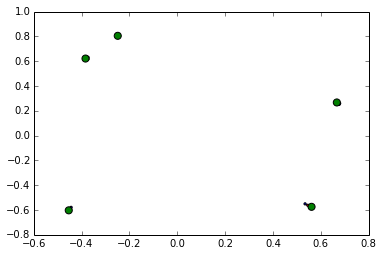

In [143]:
nx.draw_networkx_nodes(G,pos,nodelist=clusters,node_size = 5,node_color = 'r')
nx.draw_networkx_nodes(G,pos,nodelist=all_in_clusters,node_size = 5,node_color = 'b')
# nx.draw_networkx_nodes(G,pos,nodelist=non_interest_nodes,node_size = 5,node_color = 'b')
nx.draw_networkx_nodes(G,pos,nodelist=interest_nodes,node_size=50,node_color='g')
nx.draw_networkx_edges(G,pos,draw_edges)
